# Exploring variational inference solutions

We want to do variational inference by fixing the parametric family of the surrogate distribution. In this notebook we go through different ways to optimize for the parameters.

In [2]:
import general_module as gm
import numpy as np
from scipy import integrate, stats

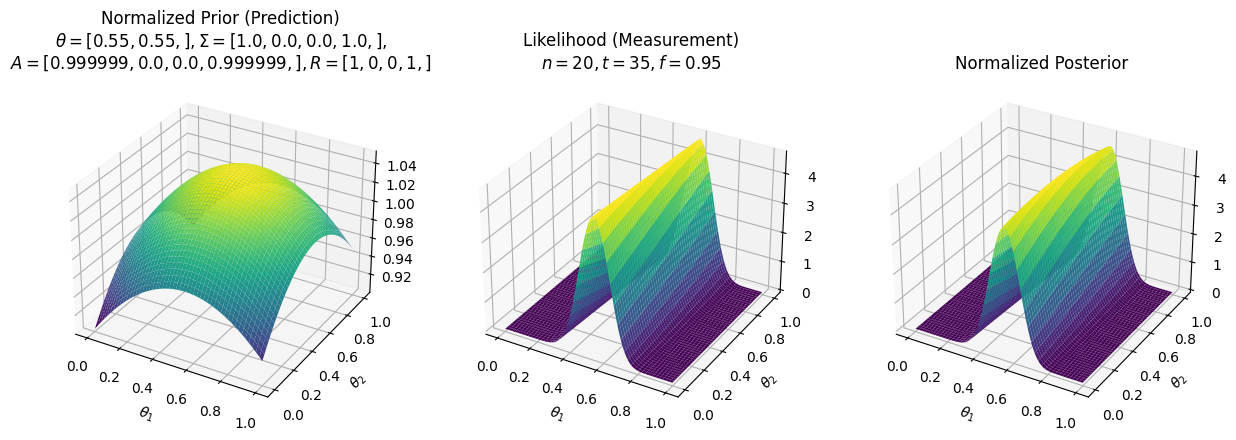

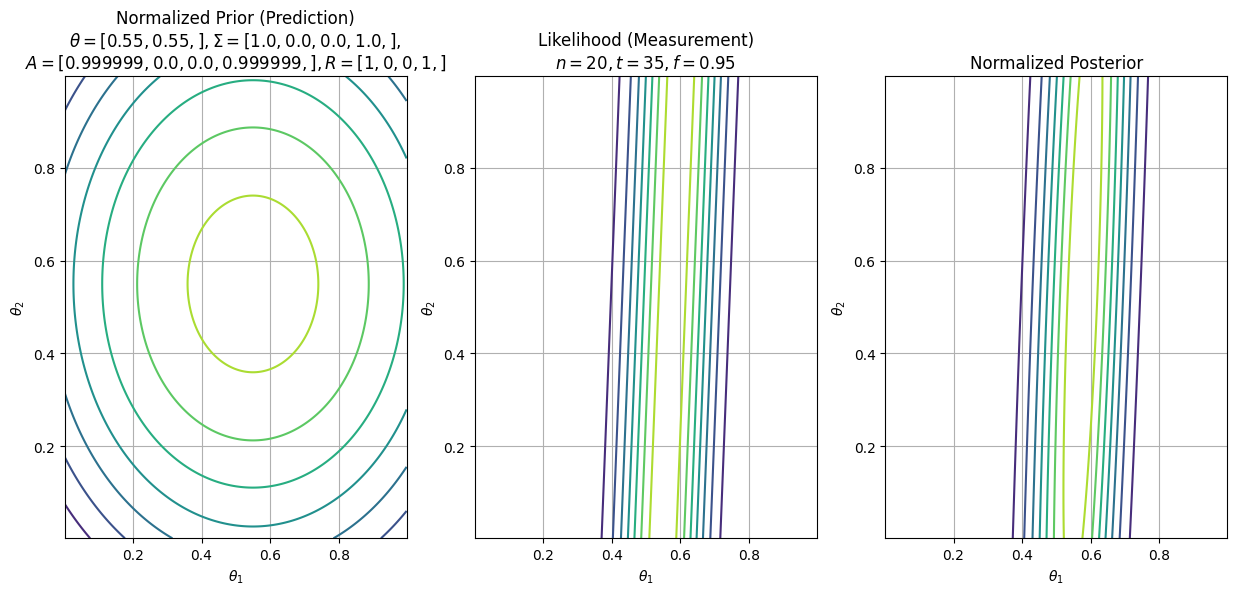

In [3]:
# Use the TkAgg backend
# %matplotlib tk
import matplotlib.pyplot as plt

"""
Define random past values
"""
past_est = gm.Estimate(np.array([0.55,0.55]), np.eye(2))
curr_obs = gm.Observation(20, 35)
past_f = 0.95

# Sensor degradation model and covariance (slow degradation)
A = np.asarray([[1-gm.ZERO_APPROX/1e3, 0],
                [0, 1-gm.ZERO_APPROX/1e3]])
R = np.asarray([[1, 0],
                [0, 1]])

"""
Execute prediction step
"""
# predicted belief: p(theta_t, n_t-1, f)
predicted_est = gm.prediction_step(past_est, A, R)

# joint dist: p(theta_t, n_t, f)
joint_dist = gm.MultiVarJointDist(dim=2)
joint_dist.update_binom_params(curr_obs.n, past_f, curr_obs.t)
joint_dist.update_norm_params(predicted_est.x, predicted_est.covar)
joint_dist.compute_norm_const()

"""
Visualize joint distribution data in 3-D
"""
support_step_size = 1e-3
support = np.arange(gm.ZERO_APPROX, 1-gm.ZERO_APPROX, support_step_size) # n points
x, y = np.meshgrid(support, support)
pos = np.vstack((x.flatten(), y.flatten())).T # (n*n) x 2 vector of coordinate points
xlab = r"$\theta_1$"
ylab = r"$\theta_2$"

fig1, ax1 = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(15, 6))
fig1.set_facecolor('white')
np.set_printoptions(formatter={'all': lambda x: " {}, ".format(x)}) # adjust inter-element whitespace

# Bivariate normal (prior/prediction); normalized to support
bivar_normal_pdf_vals = stats.multivariate_normal.pdf(pos, mean=predicted_est.x, cov=predicted_est.covar)
bivar_normal_norm_const = integrate.simpson(
    integrate.simpson(bivar_normal_pdf_vals.reshape(x.shape), support, axis=1),
    support
)
ax1[0] = gm.create_surface_plot(
    ax1[0],
    x,
    y,
    np.divide(bivar_normal_pdf_vals.reshape(x.shape), bivar_normal_norm_const),
    xlab,
    ylab,
    "Normalized Prior (Prediction)""\n"r"$\theta={}, \Sigma={},$""\n"r"$A={}, R={}$"
    .format(past_est.x.ravel(), past_est.covar.ravel(), A.ravel(), R.ravel())
)

# Binomial (likelihood); normalized to support
def p(x):
    return x[:, 0] * past_f + (1 - x[:, 1]) * (1 - past_f)
binom_pmf_vals = stats.binom.pmf(curr_obs.n, curr_obs.t, p(pos))
binom_norm_const = integrate.simpson(
    integrate.simpson(binom_pmf_vals.reshape(x.shape), support, axis=1),
    support
)
ax1[1] = gm.create_surface_plot(
    ax1[1],
    x,
    y,
    np.divide(binom_pmf_vals.reshape(x.shape), binom_norm_const),
    xlab,
    ylab,
    "Likelihood (Measurement)""\n"r"$n={}, t={}, f={}$"
    .format(curr_obs.n, curr_obs.t, past_f)
)

# Joint distribution (posterior); normalized to support
joint_pdf_vals = np.multiply(binom_pmf_vals, bivar_normal_pdf_vals)
joint_pdf_norm_const = integrate.simpson(
    integrate.simpson(joint_pdf_vals.reshape(x.shape), support, axis=1),
    support
)
ax1[2] = gm.create_surface_plot(
    ax1[2],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

"""
Visualize joint distribution data in contour plot
"""
fig2, ax2 = plt.subplots(1, 3, figsize=(15, 6))
fig2.set_facecolor('white')

# Bivariate normal (prior/prediction); normalized to support
ax2[0] = gm.create_contour_plot(
    ax2[0],
    x,
    y,
    np.divide(bivar_normal_pdf_vals.reshape(x.shape), bivar_normal_norm_const),
    xlab,
    ylab,
    "Normalized Prior (Prediction)""\n"r"$\theta={}, \Sigma={},$""\n"r"$A={}, R={}$"
    .format(past_est.x.ravel(), past_est.covar.ravel(), A.ravel(), R.ravel())
)

# Binomial (likelihood); normalized to support
ax2[1] = gm.create_contour_plot(
    ax2[1],
    x,
    y,
    np.divide(binom_pmf_vals.reshape(x.shape), binom_norm_const),
    xlab,
    ylab,
    "Likelihood (Measurement)""\n"r"$n={}, t={}, f={}$".format(curr_obs.n, curr_obs.t, past_f)
)

# Joint distribution (posterior); normalized to support
ax2[2] = gm.create_contour_plot(
    ax2[2],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

plt.show()

## Method 1: Warm starting optimization with MAP estimate
We warm start by using the MAP estimate of the joint distribution's mode as the mean for our surrogate bivariate normal distribution.

In [4]:
from scipy import optimize
"""
MAP estimation as a verification that minimization code is done correctly
"""

# Define integration limits (i.e., support) for the expectation
limits = [gm.ZERO_APPROX, 1-gm.ZERO_APPROX]

# Reconstruct the covariance matrix
def reconstruct_cov_mat(params):
    if params.size != 3: raise
    else:
        cov = np.diag(params[:2])
        corr = params[2]
        cov[0,1] = corr*np.sqrt(params[0]*params[1])
        cov[1,0] = cov[0,1]
        return cov

# Check whether eigenvalues of the covariance matrix are positive
def pos_def_constraint(params):
    if params.size == 6: cov_matrix_part = params[2:].reshape((2, 2)) # 6 values
    elif params.size == 3: cov_matrix_part = reconstruct_cov_mat(params) # 3 values
    else: cov_matrix_part = np.diag(params) # 2 values
    return (np.linalg.eigvals(cov_matrix_part) - np.array([1e-6, 1e-6])).ravel()

# Cost function for the MAP estimate
def MAP_cost_function(x):
    return -joint_dist.pdf(x)

# Warm started ELBO
def warm_start_neg_ELBO(C, mu, sigma, joint_dist: gm.MultiVarJointDist):
    """Warm started ELBO using the MAP estimates of the joint distribution
    """

    if C.size == 3:
        cov = reconstruct_cov_mat(C)
        surrogate_dist = stats.multivariate_normal(mean=mu, cov=cov) # params has 3 elements
    elif C.size == 2: surrogate_dist = stats.multivariate_normal(mean=mu, cov=np.diag(C)) # params has 2 elements
    elif C.size == 1:
        sigma[1,0] = C*np.sqrt(sigma[0,0] * sigma[1,1])
        sigma[0,1] = sigma[1,0]
        surrogate_dist = stats.multivariate_normal(mean=mu, cov=sigma) # params has 3 elements
    else: raise

    surrogate_norm_const, _ = integrate.dblquad(
        lambda x, y: surrogate_dist.pdf(np.array([x, y])), *limits, *limits
    )

    ln_expectation, _ = integrate.dblquad(
        lambda x, y: surrogate_dist.pdf(np.array([x, y])) * 
                     (
                         np.log(joint_dist.pdf(np.array([x, y]))) -
                         np.log(surrogate_dist.pdf(np.array([x, y]))) +
                         np.log(surrogate_norm_const)
                     ), *limits, *limits
    )
    return -(ln_expectation)/surrogate_norm_const

# Define initial guess as the predicted estimate
x0_map = predicted_est.x

map_result = optimize.minimize(
    MAP_cost_function,
    x0_map,
    method="SLSQP",
    bounds=[(gm.ZERO_APPROX,1-gm.ZERO_APPROX), (gm.ZERO_APPROX,1-gm.ZERO_APPROX)]
)

print("\n###### Optimization results ######\n")
print(map_result)
print("Estimated mean:\n", map_result.x)
print("Cost", -map_result.fun)
print("\n####################################\n")


###### Optimization results ######

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -4.74301252157463
       x: [ 5.776e-01  5.485e-01]
     nit: 4
     jac: [-2.473e-03  3.111e-05]
    nfev: 16
    njev: 4
Estimated mean:
 [ 0.577629605934976,   0.5485032316452157, ]
Cost 4.74301252157463

####################################



### 1A: Constrain surrogate covariance to be diagonal (_i.e._, no correlation)
This constraint simplifies the problem since only 2 of the 4 covariance matrix elements are optimized over; the off-diagonal values are set to 0.

In [5]:
"""
Warm start the minimization of the ELBO
"""

# Define bounds for the optimization problem
bnds_warm_start_1a = [*[(gm.ZERO_APPROX, np.inf) for _ in range(2)]] # 2 variables: c_11, c_22

# Define positive definiteness constraint
pos_def_constraint_dict = {"type": "ineq", "fun": pos_def_constraint}

# Define initial guess as predicted covariance
x0_warm_start_1a = [predicted_est.covar[0,0], predicted_est.covar[1,1]]

warm_start_result_1a = optimize.minimize(
    warm_start_neg_ELBO,
    x0_warm_start_1a,
    args=(map_result.x, None, joint_dist),
    method="SLSQP",
    bounds=bnds_warm_start_1a,
    constraints=pos_def_constraint_dict
)

print("\n###### Optimization result ######\n")
print(warm_start_result_1a)
print("Estimated covariance matrix:\n", np.diag(warm_start_result_1a.x))
print("ELBO", -warm_start_result_1a.fun)
print("\n####################################\n")

/home/khaiyichin/research/sensor_degradation_filter/.venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



###### Optimization result ######

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.020831218734567176
       x: [ 6.975e-03  1.990e+00]
     nit: 9
     jac: [ 2.602e-02  1.852e-04]
    nfev: 34
    njev: 9
Estimated covariance matrix:
 [[ 0.006975448504146692,   0.0, ]
 [ 0.0,   1.9897583948526056, ]]
ELBO -0.020831218734567176

####################################



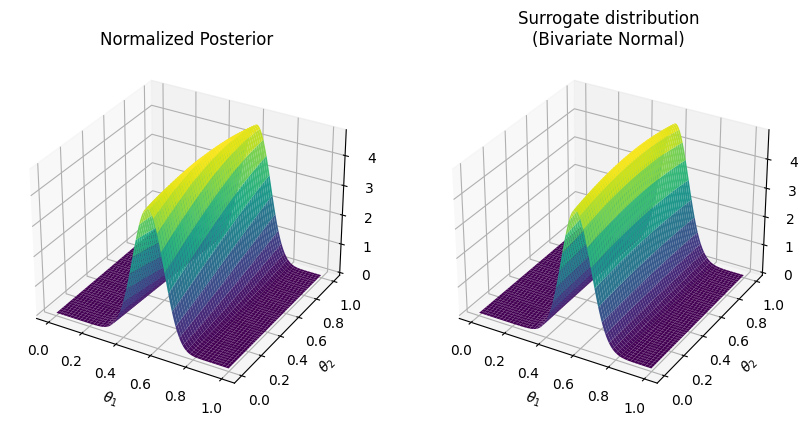

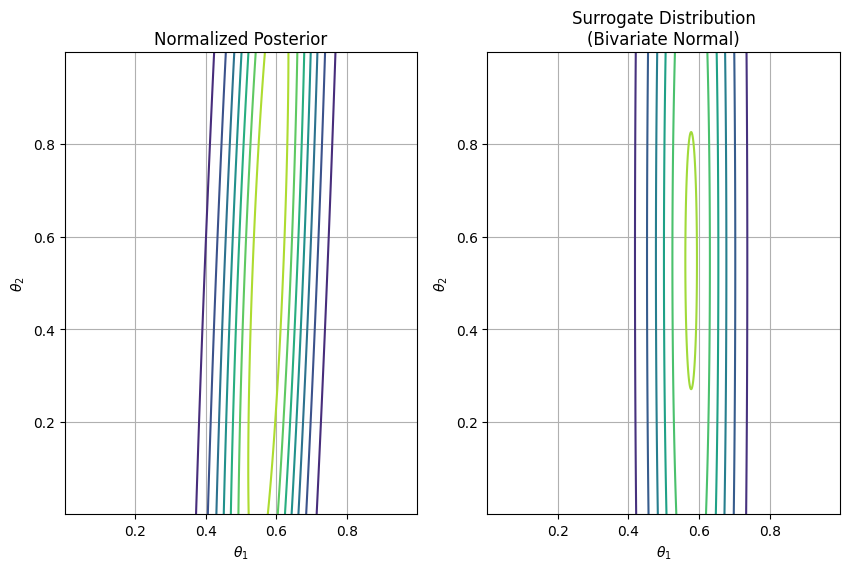

In [6]:
"""
Plot result
"""
fig3, ax3 = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={"projection": "3d"})
fig3.set_facecolor('white')

# Joint distribution (posterior); normalized to support
ax3[0] = gm.create_surface_plot(
    ax3[0],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

# Surrogate distribution; normalized to support
approx_dist_pdf_vals_1a = stats.multivariate_normal.pdf(pos, mean=map_result.x, cov=np.diag(warm_start_result_1a.x)) # params has 2 elements
approx_dist_norm_const_1a = integrate.simpson(
    integrate.simpson(approx_dist_pdf_vals_1a.reshape(x.shape), support, axis=1),
    support
)
ax3[1] = gm.create_surface_plot(
    ax3[1],
    x,
    y,
    np.divide(approx_dist_pdf_vals_1a.reshape(x.shape), approx_dist_norm_const_1a),
    xlab,
    ylab,
    "Surrogate distribution\n(Bivariate Normal)"
)

"""
Comparison using contour plot
"""
fig4, ax4 = plt.subplots(1, 2, figsize=(10, 6))
fig4.set_facecolor('white')

# Joint distribution (posterior); normalized to support
ax4[0] = gm.create_contour_plot(
    ax4[0],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

# Surrogate distribution; normalized to support
ax4[1] = gm.create_contour_plot(
    ax4[1],
    x,
    y,
    np.divide(approx_dist_pdf_vals_1a.reshape(x.shape), approx_dist_norm_const_1a),
    xlab,
    ylab,
    "Surrogate Distribution\n(Bivariate Normal)"
)

### 1B: Use 1A to warm start search for correlation
Using the result from 1A, search only for the off-diagonal term.

In [8]:
# Define bounds for the optimization problem
bnds_warm_start_1b = [(-1, 1)] # 3 variables: c_11, c_22, correlation

# Define positive definiteness constraint
def pos_def_constraint_corr(params):
    cov_matrix_part = np.diag(warm_start_result_1a.x)
    cov_matrix_part[0,1] = params[0]
    cov_matrix_part[1,0] = cov_matrix_part[0,1]
    return (np.linalg.eigvals(cov_matrix_part) - np.array([1e-6, 1e-6])).ravel()
pos_def_constraint_corr_dict = {"type": "ineq", "fun": pos_def_constraint_corr}

# Define initial guess as predicted covariance with 0 correlation
x0_warm_start_1b = [0.25]

# Define integration limits (i.e., support) for the expectation
limits = [gm.ZERO_APPROX, 1-gm.ZERO_APPROX]

warm_start_result_1b = optimize.minimize(
    warm_start_neg_ELBO,
    x0_warm_start_1b,
    args=(map_result.x, np.diag(warm_start_result_1a.x), joint_dist),
    method="SLSQP",
    bounds=bnds_warm_start_1b,
    constraints=pos_def_constraint_corr_dict,
    # options={"eps": 1e-3}
)

print("\n###### Optimization result ######\n")
print(warm_start_result_1b)
print("Estimated correlation:\n", warm_start_result_1b.x)
print("ELBO", -warm_start_result_1b.fun)
print("\n####################################\n")


###### Optimization result ######

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.016595137022671888
       x: [ 1.178e-01]
     nit: 5
     jac: [-3.193e-02]
    nfev: 10
    njev: 5
Estimated correlation:
 [ 0.11780264649087269, ]
ELBO -0.016595137022671888

####################################



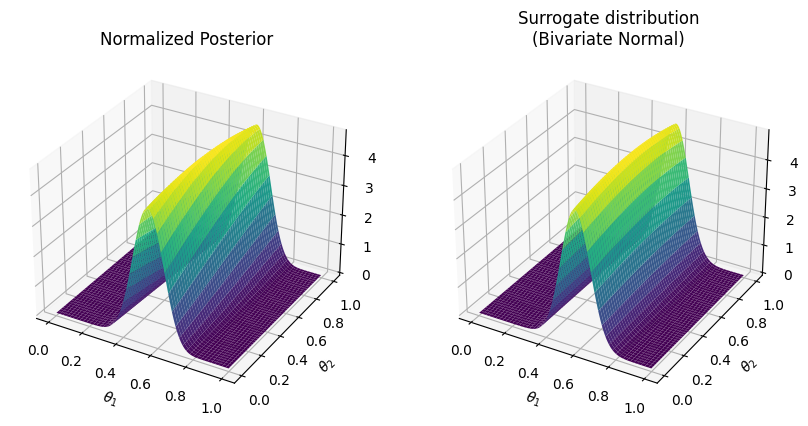

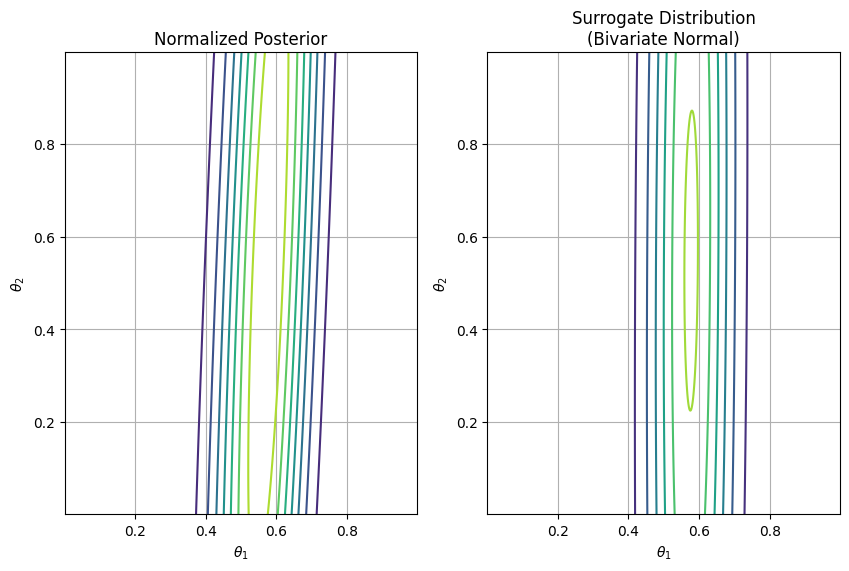

In [9]:
"""
Plot result
"""
fig5, ax5 = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={"projection": "3d"})
fig5.set_facecolor('white')

# Joint distribution (posterior); normalized to support
ax5[0] = gm.create_surface_plot(
    ax5[0],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

# Surrogate distribution; normalized to support
covar_1b = np.diag(warm_start_result_1a.x)
covar_1b[0,1] = warm_start_result_1b.x*np.sqrt(covar_1b[0,0] * covar_1b[1,1])
covar_1b[1,0] = covar_1b[0,1]
approx_dist_pdf_vals_1b = stats.multivariate_normal.pdf(pos, mean=map_result.x, cov=covar_1b)
approx_dist_norm_const_1b = integrate.simpson(
    integrate.simpson(approx_dist_pdf_vals_1b.reshape(x.shape), support, axis=1),
    support
)
ax5[1] = gm.create_surface_plot(
    ax5[1],
    x,
    y,
    np.divide(approx_dist_pdf_vals_1b.reshape(x.shape), approx_dist_norm_const_1b),
    xlab,
    ylab,
    "Surrogate distribution\n(Bivariate Normal)"
)

"""
Comparison using contour plot
"""
fig6, ax6 = plt.subplots(1, 2, figsize=(10, 6))
fig6.set_facecolor('white')

# Joint distribution (posterior); normalized to support
ax6[0] = gm.create_contour_plot(
    ax6[0],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

# Surrogate distribution; normalized to support
ax6[1] = gm.create_contour_plot(
    ax6[1],
    x,
    y,
    np.divide(approx_dist_pdf_vals_1b.reshape(x.shape), approx_dist_norm_const_1b),
    xlab,
    ylab,
    "Surrogate Distribution\n(Bivariate Normal)"
)

### 1C: Warm start with 1A+1B covariance matrix but re-search covariance matrix
Using the solution found in 1A and 1B as initial guess, optimize over all values of the covariance matrix.

In [10]:
# Define bounds for the optimization problem
bnds_warm_start_1c = [*[(gm.ZERO_APPROX, np.inf) for _ in range(2)], (-1, 1)] # 3 variables: c_11, c_22, correlation

# Define positive definiteness constraint
pos_def_constraint_dict = {"type": "ineq", "fun": pos_def_constraint}

# Define initial guess as predicted covariance with 0 correlation
x0_warm_start_1c = [warm_start_result_1a.x[0], warm_start_result_1a.x[1], warm_start_result_1b.x[0]]

# Define integration limits (i.e., support) for the expectation
limits = [gm.ZERO_APPROX, 1-gm.ZERO_APPROX]

warm_start_result_1c = optimize.minimize(
    warm_start_neg_ELBO,
    x0_warm_start_1c,
    args=(map_result.x, None, joint_dist),
    method="SLSQP",
    bounds=bnds_warm_start_1c,
    constraints=pos_def_constraint_dict,
    options={"eps": 1e-2}
)

print("\n###### Optimization result ######\n")
print(warm_start_result_1c)
print("Estimated covariance matrix:\n", reconstruct_cov_mat(warm_start_result_1c.x))
print("ELBO", -warm_start_result_1c.fun)
print("\n####################################\n")


###### Optimization result ######

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.016598218609745495
       x: [ 6.974e-03  1.990e+00  1.178e-01]
     nit: 3
     jac: [ 3.142e+01  1.141e-03 -3.143e-02]
    nfev: 43
    njev: 3
Estimated covariance matrix:
 [[ 0.00697430584729222,   0.013872169308570525, ]
 [ 0.013872169308570525,   1.9897599537153534, ]]
ELBO -0.016598218609745495

####################################



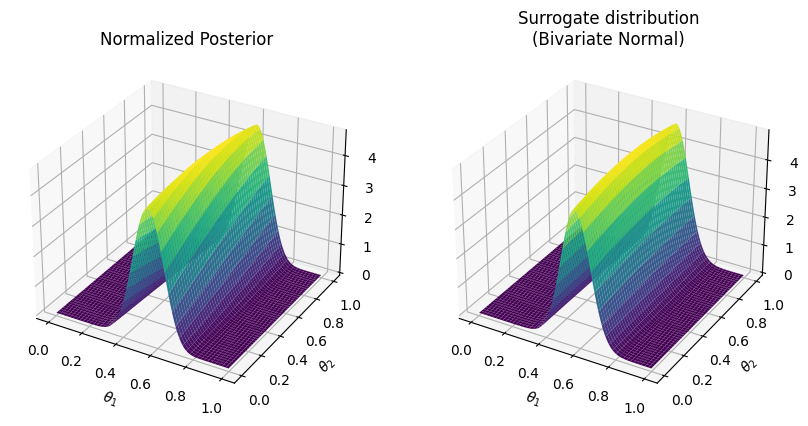

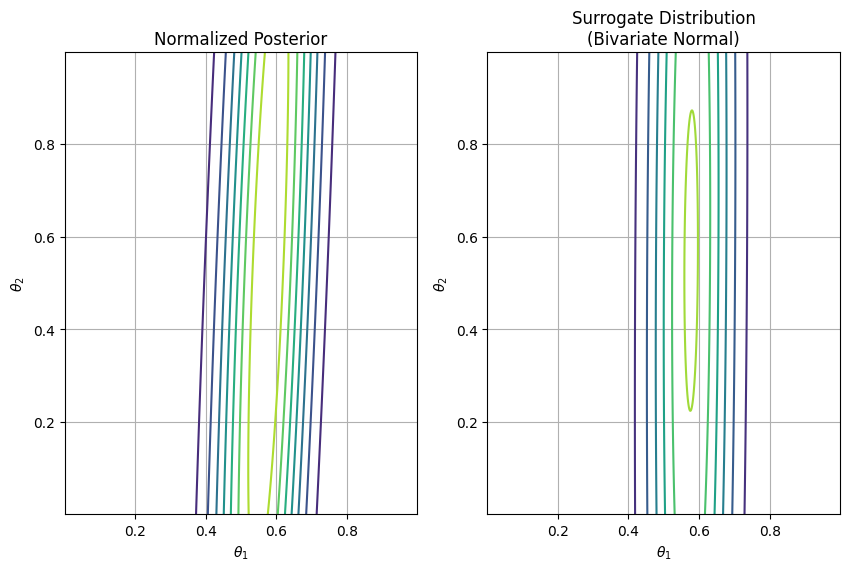

In [11]:
"""
Plot result
"""
fig7, ax7 = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={"projection": "3d"})
fig7.set_facecolor('white')

# Joint distribution (posterior); normalized to support
ax7[0] = gm.create_surface_plot(
    ax7[0],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

# Surrogate distribution; normalized to support
covar_1c = reconstruct_cov_mat(warm_start_result_1c.x)
approx_dist_pdf_vals_1c = stats.multivariate_normal.pdf(pos, mean=map_result.x, cov=covar_1c)
approx_dist_norm_const_1c = integrate.simpson(
    integrate.simpson(approx_dist_pdf_vals_1c.reshape(x.shape), support, axis=1),
    support
)
ax7[1] = gm.create_surface_plot(
    ax7[1],
    x,
    y,
    np.divide(approx_dist_pdf_vals_1c.reshape(x.shape), approx_dist_norm_const_1c),
    xlab,
    ylab,
    "Surrogate distribution\n(Bivariate Normal)"
)

"""
Comparison using contour plot
"""
fig8, ax8 = plt.subplots(1, 2, figsize=(10, 6))
fig8.set_facecolor('white')

# Joint distribution (posterior); normalized to support
ax8[0] = gm.create_contour_plot(
    ax8[0],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

# Surrogate distribution; normalized to support
ax8[1] = gm.create_contour_plot(
    ax8[1],
    x,
    y,
    np.divide(approx_dist_pdf_vals_1c.reshape(x.shape), approx_dist_norm_const_1c),
    xlab,
    ylab,
    "Surrogate Distribution\n(Bivariate Normal)"
)

### 1D: Warm start only with mean but search covariance matrix
With no guidance, optimize over the covariance matrix values.

In [12]:
# Define bounds for the optimization problem
bnds_warm_start_1d = [*[(gm.ZERO_APPROX, np.inf) for _ in range(2)], (-1, 1)] # 3 variables: c_11, c_22, correlation

# Define positive definiteness constraint
pos_def_constraint_dict = {"type": "ineq", "fun": pos_def_constraint}

# Define initial guess as predicted covariance with 0 correlation
x0_warm_start_1d = [predicted_est.covar[0,0], predicted_est.covar[1,1], x0_warm_start_1b[0]]

# Define integration limits (i.e., support) for the expectation
limits = [gm.ZERO_APPROX, 1-gm.ZERO_APPROX]

warm_start_result_1d = optimize.minimize(
    warm_start_neg_ELBO,
    x0_warm_start_1d,
    args=(map_result.x, None, joint_dist),
    method="SLSQP",
    bounds=bnds_warm_start_1d,
    constraints=pos_def_constraint_dict,
    options={"eps": 1e-2}
)

print("\n###### Optimization result ######\n")
print(warm_start_result_1d)
print("Estimated covariance matrix:\n", warm_start_result_1d.x)
print("ELBO", -warm_start_result_1d.fun)
print("\n####################################\n")

/home/khaiyichin/research/sensor_degradation_filter/.venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/tmp/ipykernel_1506037/951541407.py:53: RuntimeWarning: divide by zero encountered in log
  np.log(surrogate_dist.pdf(np.array([x, y]))) +
/tmp/ipykernel_1506037/951541407.py:50: RuntimeWarning: invalid value encountered in multiply
  lambda x, y: surrogate_dist.pdf(np.array([x, y])) *
/home/khaiyichin/research/sensor_degradation_filter/.venv/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,



###### Optimization result ######

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.22805565049523702
       x: [ 1.697e-01  3.314e+00  9.682e-01]
     nit: 18
     jac: [ 3.313e+00 -6.767e-02 -5.745e+00]
    nfev: 99
    njev: 18
Estimated covariance matrix:
 [ 0.16970209427572303,   3.313529956115593,   0.96816281336018, ]
ELBO -0.22805565049523702

####################################



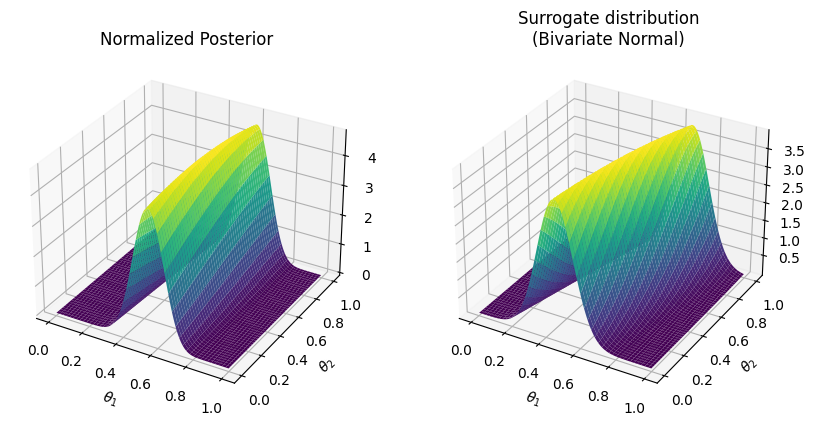

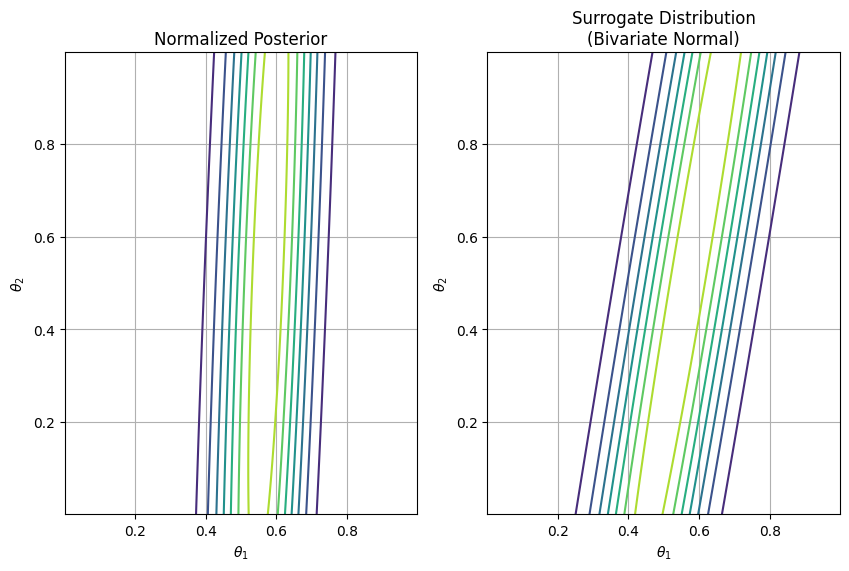

In [13]:
"""
Plot result
"""
fig5, ax5 = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={"projection": "3d"})
fig5.set_facecolor('white')

# Joint distribution (posterior); normalized to support
ax5[0] = gm.create_surface_plot(
    ax5[0],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

# Surrogate distribution; normalized to support
covar_1d = reconstruct_cov_mat(warm_start_result_1d.x)
approx_dist_pdf_vals_1d = stats.multivariate_normal.pdf(pos, mean=map_result.x, cov=covar_1d)
approx_dist_norm_const_1d = integrate.simpson(
    integrate.simpson(approx_dist_pdf_vals_1d.reshape(x.shape), support, axis=1),
    support
)
ax5[1] = gm.create_surface_plot(
    ax5[1],
    x,
    y,
    np.divide(approx_dist_pdf_vals_1d.reshape(x.shape), approx_dist_norm_const_1d),
    xlab,
    ylab,
    "Surrogate distribution\n(Bivariate Normal)"
)

"""
Comparison using contour plot
"""
fig6, ax6 = plt.subplots(1, 2, figsize=(10, 6))
fig6.set_facecolor('white')

# Joint distribution (posterior); normalized to support
ax6[0] = gm.create_contour_plot(
    ax6[0],
    x,
    y,
    np.divide(joint_pdf_vals.reshape(x.shape), joint_pdf_norm_const),
    xlab,
    ylab,
    "Normalized Posterior"
)

# Surrogate distribution; normalized to support
ax6[1] = gm.create_contour_plot(
    ax6[1],
    x,
    y,
    np.divide(approx_dist_pdf_vals_1d.reshape(x.shape), approx_dist_norm_const_1d),
    xlab,
    ylab,
    "Surrogate Distribution\n(Bivariate Normal)"
)

## Method 2: Search everything from scratch
This doesn't make sense since the previous methods already take so much time. Additionally, having the mean of the surrogate distribution as the MAP estimate is likely the best outcome, so in that sense the search for the covariance matrix follows Method 1.